## Bibliotecas

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error

## Leitura dos Dados

In [11]:
df = pd.read_csv('https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.csv')
df.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [13]:
df.isnull().sum()

,0
longitude,0
latitude,0
housing_median_age,0
total_rooms,0
total_bedrooms,207
population,0
households,0
median_income,0
median_house_value,0
ocean_proximity,0


## 1. Análise Exploratória

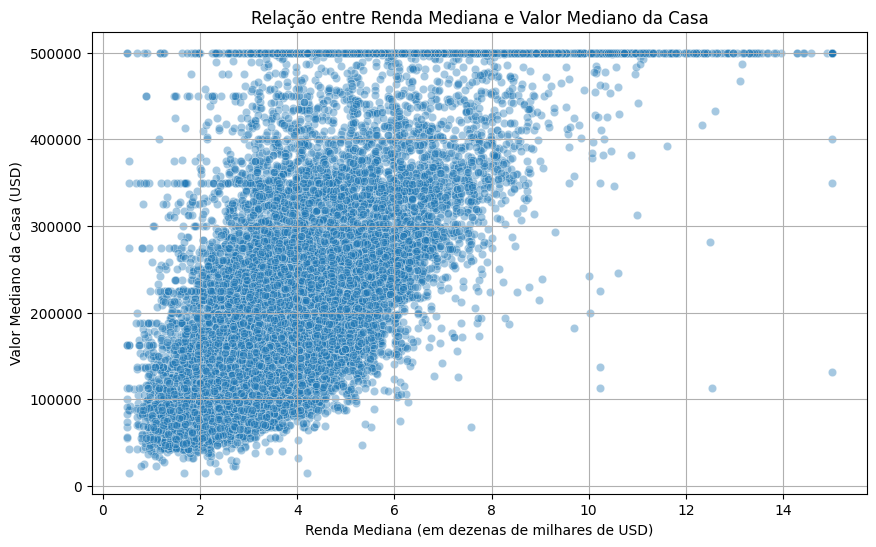

In [7]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='median_income', y='median_house_value', alpha=0.4)
plt.title('Relação entre Renda Mediana e Valor Mediano da Casa')
plt.xlabel('Renda Mediana (em dezenas de milhares de USD)')
plt.ylabel('Valor Mediano da Casa (USD)')
plt.grid(True)
plt.show()

Ao criar o gráfico de dispersão, observo uma relação positiva clara e forte entre a renda mediana e o valor mediano das casas. A nuvem de pontos se estende do canto inferior esquerdo para o canto superior direito, indicando que, à medida que a renda mediana em uma região aumenta, o valor mediano das casas nessa mesma região também tende a aumentar. Existe uma correlação evidente. No entanto, a relação não é perfeitamente linear.

## Pré-processamento

In [14]:
df['total_bedrooms'] = df['total_bedrooms'].fillna(df['total_bedrooms'].median())

df['rooms_per_household'] = df['total_rooms'] / df['households']
df['bedrooms_per_room'] = df['total_bedrooms'] / df['total_rooms']
df['population_per_household'] = df['population'] / df['households']

df_encoded = pd.get_dummies(df, columns=['ocean_proximity'], drop_first=True)

X = df_encoded.drop('median_house_value', axis=1)
y = df_encoded['median_house_value']

## 2. Divisão dos dados

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Tamanho do conjunto de treinamento: {X_train.shape[0]} amostras")
print(f"Tamanho do conjunto de teste: {X_test.shape[0]} amostras")

Tamanho do conjunto de treinamento: 14448 amostras
Tamanho do conjunto de teste: 6192 amostras


É fundamental dividir os dados em conjuntos de treinamento e teste para avaliar a capacidade de generalização do modelo. O conjunto de teste funciona como uma simulação de dados do mundo real, permitindo uma avaliação honesta e imparcial de quão bem o modelo realmente aprendeu os padrões nos dados.

## 3. Análise de outliers

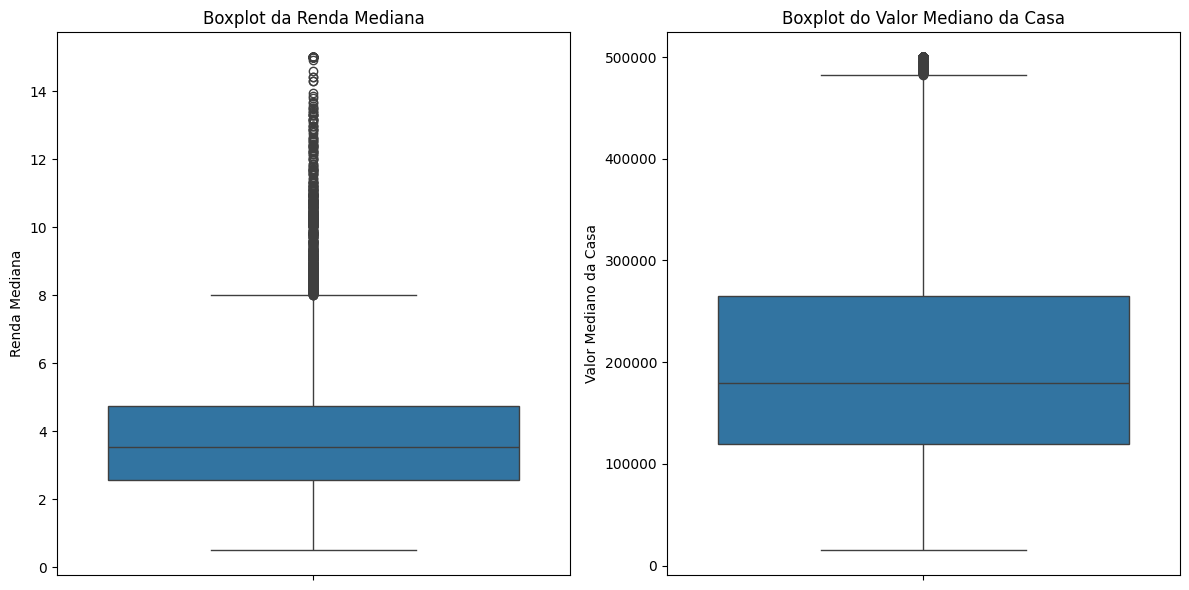

In [16]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(y=df['median_income'])
plt.title('Boxplot da Renda Mediana')
plt.ylabel('Renda Mediana')

plt.subplot(1, 2, 2)
sns.boxplot(y=df['median_house_value'])
plt.title('Boxplot do Valor Mediano da Casa')
plt.ylabel('Valor Mediano da Casa')

plt.tight_layout()
plt.show()

Para a `median_house_value`, o boxplot mostra uma grande concentração de pontos no limite superior, correspondendo à linha de $500,000. Já para a `median_income`, o boxplot mostra vários pontos acima do "bigode" superior, indicando que existem algumas regiões com renda mediana significativamente mais alta que a maioria.

## 4. Seleção de variáveis

In [17]:
model_all_features = LinearRegression()
model_all_features.fit(X_train, y_train)
y_pred_all = model_all_features.predict(X_test)
mae_all = mean_absolute_error(y_test, y_pred_all)
print(f"MAE do Modelo de Regressão Linear (Todas as Variáveis): ${mae_all:,.2f}")

features_selected = ['median_income', 'housing_median_age', 'rooms_per_household']
X_train_selected = X_train[features_selected]
X_test_selected = X_test[features_selected]

model_selected_features = LinearRegression()
model_selected_features.fit(X_train_selected, y_train)
y_pred_selected = model_selected_features.predict(X_test_selected)
mae_selected = mean_absolute_error(y_test, y_pred_selected)
print(f"MAE do Modelo de Regressão Linear (Variáveis Selecionadas): ${mae_selected:,.2f}")

MAE do Modelo de Regressão Linear (Todas as Variáveis): $50,019.70
MAE do Modelo de Regressão Linear (Variáveis Selecionadas): $59,680.47


Ao usar apenas uma seleção de três variáveis, o desempenho do modelo de regressão linear foi pior (teve um MAE maior) do que o modelo que usava todas as variáveis. O erro médio absoluto aumentou, indicando que as previsões do modelo mais simples estão, em média, mais distantes dos valores reais.

Isso acontece porque, embora `median_income` seja um forte preditor, variáveis que foram deixadas de fora, como a localização geográfica (latitude e longitude), são extremamente importantes para determinar o preço de um imóvel.

## 5. Árvore de decisão para regressão

In [18]:
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict(X_test)
mae_tree = mean_absolute_error(y_test, y_pred_tree)

print(f"Resumo de Desempenho (Erro Médio Absoluto - MAE):")
print(f"  - Regressão Linear (Todas as Variáveis): ${mae_all:,.2f}")
print(f"  - Árvore de Decisão: ${mae_tree:,.2f}")

Resumo de Desempenho (Erro Médio Absoluto - MAE):
  - Regressão Linear (Todas as Variáveis): $50,019.70
  - Árvore de Decisão: $45,244.97


Comparando os resultados, a Árvore de Decisão apresentou um desempenho melhor (um MAE menor) do que o modelo de Regressão Linear.

A principal razão para isso é a natureza dos modelos. A Regressão Linear é um modelo linear, o que significa que ele assume que a relação entre as variáveis de entrada e o preço da casa pode ser representada por uma linha reta (ou um hiperplano).

Já as Árvores de Decisão, por outro lado, são modelos não lineares. Elas funcionam dividindo os dados em subconjuntos com base em "perguntas" sobre as variáveis (ex: "a renda mediana é maior que X?"). Esse método permite que elas capturem interações complexas e relações não lineares de forma muito mais eficaz, o que geralmente resulta em previsões mais precisas.